### Importing Required Libraries

In [ ]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pad_sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pad-sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10216 sha256=9b9a0ea8cca773a4aa551b98dddda78648c4d296c51a21a4aa0f694e374b5e7e
  Stored in directory: /root/.cache/pip/wheels/3f/80/05/48e28be7b6bde8b3378f747f50bc32a87cb281c2e89ae74500
Successfully built pad-sequences


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix

### Authentication to Google Drive Files

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Access to file

In [ ]:
# link = 'https://drive.google.com/file/d/17VnKTmYjjqYQ1WtBDIhSyEhIV6Ennu0N/view?usp=share_link
id = '17VnKTmYjjqYQ1WtBDIhSyEhIV6Ennu0N'

In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FlairAnalysis.csv',)  

### Load dataset

In [ ]:
data = pd.read_csv('FlairAnalysis.csv',index_col=[0])
data

,text,Cleaned_tweets,probability,sentiment
0,RT @StrikeMapUK: The Cost of Living Crisis is ...,cost living crisis political choice yet tory t...,0.924938,NEGATIVE
1,RT @0Calamity: This is not a #CostOfLivingCris...,costoflivingcrisis stateimposedpoverty do quit...,0.865847,POSITIVE
2,RT @geoffh33: Every non-Tory MP should have st...,every non tory mp stand today call borisjohnso...,0.987879,NEGATIVE
3,RT @hewitson10: Ian Blackford owned the show a...,ian blackford own show always tory care costof...,0.544504,NEGATIVE
4,RT @snowy2007: Serious question for Scottish P...,serious question scottish power say energy gre...,0.600847,POSITIVE
...,...,...,...,...
541723,RT @SB_Sarah10: Do you honestly think #LizTrus...,honestly think liztruss plan cost living crisis,0.993839,NEGATIVE
541724,"RT @michaelbartrum: Every hour, 10 people die ...",every hour people die poverty uk rise costofli...,0.996808,NEGATIVE
541725,Jesus! £170 billion excess profits over 2 yrs!...,jesus billion excess profit yrs time take stre...,0.689607,NEGATIVE
541726,RT @maxwellwoodger: Attended the Final @Conser...,attend final leadership debate uk husting fell...,0.690461,NEGATIVE


Create copy of dataset

In [ ]:
newdata = data.copy()
newdata

,text,Cleaned_tweets,probability,sentiment
0,RT @StrikeMapUK: The Cost of Living Crisis is ...,cost living crisis political choice yet tory t...,0.924938,NEGATIVE
1,RT @0Calamity: This is not a #CostOfLivingCris...,costoflivingcrisis stateimposedpoverty do quit...,0.865847,POSITIVE
2,RT @geoffh33: Every non-Tory MP should have st...,every non tory mp stand today call borisjohnso...,0.987879,NEGATIVE
3,RT @hewitson10: Ian Blackford owned the show a...,ian blackford own show always tory care costof...,0.544504,NEGATIVE
4,RT @snowy2007: Serious question for Scottish P...,serious question scottish power say energy gre...,0.600847,POSITIVE
...,...,...,...,...
541723,RT @SB_Sarah10: Do you honestly think #LizTrus...,honestly think liztruss plan cost living crisis,0.993839,NEGATIVE
541724,"RT @michaelbartrum: Every hour, 10 people die ...",every hour people die poverty uk rise costofli...,0.996808,NEGATIVE
541725,Jesus! £170 billion excess profits over 2 yrs!...,jesus billion excess profit yrs time take stre...,0.689607,NEGATIVE
541726,RT @maxwellwoodger: Attended the Final @Conser...,attend final leadership debate uk husting fell...,0.690461,NEGATIVE


In [ ]:
#Is there any other different value than neutral, negative and positive?
newdata['sentiment'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = data['Cleaned_tweets'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(data_to_list[i])
list(temp[:5])

['cost living crisis political choice yet tory try make ordinary people pay join ppls',
 'costoflivingcrisis stateimposedpoverty do quite deliberately able please',
 'every non tory mp stand today call borisjohnson liar hoyle would ask leave chamb',
 'ian blackford own show always tory care costoflivingcrisis go piss',
 'serious question scottish power say energy green justify rise']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['cost', 'living', 'crisis', 'political', 'choice', 'yet', 'tory', 'try', 'make', 'ordinary', 'people', 'pay', 'join', 'ppls'], ['do', 'quite', 'deliberately', 'able', 'please'], ['every', 'non', 'tory', 'mp', 'stand', 'today', 'call', 'borisjohnson', 'liar', 'hoyle', 'would', 'ask', 'leave', 'chamb'], ['ian', 'blackford', 'own', 'show', 'always', 'tory', 'care', 'go', 'piss'], ['serious', 'question', 'scottish', 'power', 'say', 'energy', 'green', 'justify', 'rise'], ['brian', 'see', 'impact', 'every', 'time', 'volunteer', 'food', 'bank', 'nobody', 'get'], ['conservative', 'snp', 'ferryfiasco', 'nhs', 'ukraine', 'borisjohnson', 'partygate', 'oligarchs', 'covidisntover', 'nhs'], [], ['worth', 'repeat', 'thank', 'know', 'headline', 'inflation', 'worth', 'repeat', 'uk', 'low', 'state', 'pension', 'west', 'europe', 'worth', 'repeat', 'euro', 'nation', 'much', 'energy', 'price', 'crisis'], ['do', 'quite', 'deliberately', 'able', 'please']]


In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
newdata = []
for i in range(len(data_words)):
    newdata.append(detokenize(data_words[i]))
print(newdata[:5])

['cost living crisis political choice yet tory try make ordinary people pay join ppls', 'do quite deliberately able please', 'every non tory mp stand today call borisjohnson liar hoyle would ask leave chamb', 'ian blackford own show always tory care go piss', 'serious question scottish power say energy green justify rise']


In [ ]:
newdata = np.array(newdata)
newdata

array(['cost living crisis political choice yet tory try make ordinary people pay join ppls',
       'do quite deliberately able please',
       'every non tory mp stand today call borisjohnson liar hoyle would ask leave chamb',
       ...,
       'jesus billion excess profit yrs time take street enoughlsenough energycrisis',
       'attend final leadership debate uk husting fellow tory londoner vs rishi',
       'borisjohnson plan visit site great achievement'], dtype='<U283')

Encoding: Convert sentiment Positve or Negative to binary 1 or 0

In [ ]:
labels = np.array(data['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'NEGATIVE':
        y.append(0)
    if labels[i] == 'POSITIVE':
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
len(labels)

541512

In [ ]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(newdata)
sequences = tokenizer.texts_to_sequences(newdata)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    3   16  153]
 [   0    0    0 ... 2029  365   55]
 [   0    0    0 ...   29  125  102]
 ...
 [   0    0    0 ...  201 1214  148]
 [   0    0    0 ... 3107 1839  189]
 [   0    0    0 ... 2399  136 1961]]


In [ ]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [ ]:
len(labels)

541512

Train and split the data using 30%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size= 0.3,stratify=labels,random_state=42)
print (len(X_train),len(X_test),len(y_train),len(y_test))

379058 162454 379058 162454


###SimpleRNN model

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='relu'))

model0.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test), callbacks=[checkpoint0])


Epoch 1/5
11845/11846 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.7170
Epoch 1: val_accuracy improved from -inf to 0.69100, saving model to best_model0.hdf5
11846/11846 [==============================] - 536s 45ms/step - loss: nan - accuracy: 0.7170 - val_loss: nan - val_accuracy: 0.6910
Epoch 2/5
11845/11846 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.6910
Epoch 2: val_accuracy did not improve from 0.69100
11846/11846 [==============================] - 530s 45ms/step - loss: nan - accuracy: 0.6910 - val_loss: nan - val_accuracy: 0.6910
Epoch 3/5
11846/11846 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6910
Epoch 3: val_accuracy did not improve from 0.69100
11846/11846 [==============================] - 525s 44ms/step - loss: nan - accuracy: 0.6910 - val_loss: nan - val_accuracy: 0.6910
Epoch 4/5
11845/11846 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.6910
Epoch 4: val_accuracy did not im

###Single LSTM layer model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/5
11846/11846 [==============================] - ETA: 0s - loss: 0.4165 - accuracy: 0.8095
Epoch 1: val_accuracy improved from -inf to 0.83248, saving model to best_model1.hdf5
11846/11846 [==============================] - 1010s 85ms/step - loss: 0.4165 - accuracy: 0.8095 - val_loss: 0.3710 - val_accuracy: 0.8325
Epoch 2/5
11846/11846 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8297
Epoch 2: val_accuracy improved from 0.83248 to 0.84159, saving model to best_model1.hdf5
11846/11846 [==============================] - 1008s 85ms/step - loss: 0.3778 - accuracy: 0.8297 - val_loss: 0.3521 - val_accuracy: 0.8416
Epoch 3/5
11846/11846 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.8364
Epoch 3: val_accuracy improved from 0.84159 to 0.84531, saving model to best_model1.hdf5
11846/11846 [==============================] - 1004s 85ms/step - loss: 0.3657 - accuracy: 0.8364 - val_loss: 0.3530 - val_accuracy: 0.8453
Epoch 4/5
11846/11846 

####Bidirectional LTSM model

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
11846/11846 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.8077
Epoch 1: val_accuracy improved from -inf to 0.83545, saving model to best_model2.hdf5
11846/11846 [==============================] - 1679s 141ms/step - loss: 0.4185 - accuracy: 0.8077 - val_loss: 0.3697 - val_accuracy: 0.8354
Epoch 2/5
11846/11846 [==============================] - ETA: 0s - loss: 0.3730 - accuracy: 0.8332
Epoch 2: val_accuracy improved from 0.83545 to 0.84573, saving model to best_model2.hdf5
11846/11846 [==============================] - 1682s 142ms/step - loss: 0.3730 - accuracy: 0.8332 - val_loss: 0.3522 - val_accuracy: 0.8457
Epoch 3/5
11846/11846 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8400
Epoch 3: val_accuracy improved from 0.84573 to 0.84866, saving model to best_model2.hdf5
11846/11846 [==============================] - 1653s 140ms/step - loss: 0.3604 - accuracy: 0.8400 - val_loss: 0.3469 - val_accuracy: 0.8487
Epoch 4/5
11846/118

### Evaluating Best Model Obtained

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)


5077/5077 - 122s - loss: 0.3357 - accuracy: 0.8523 - 122s/epoch - 24ms/step
Model accuracy:  0.852308988571167


In [ ]:
predictions = best_model.predict(X_test)

5077/5077 [==============================] - 130s 25ms/step


In [ ]:
matrix = confusion_matrix( y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
matrix

array([[105458,   6797],
       [ 17196,  33003]])

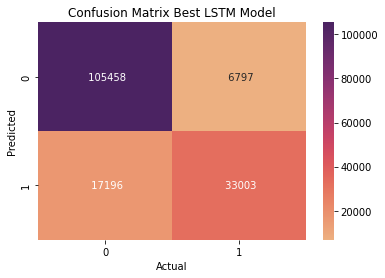

In [ ]:
ax=sns.heatmap(matrix,annot=True,cmap='flare',fmt=' ')
ax.set_title('Confusion Matrix Best LSTM Model')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.savefig('Best_LSTM_Model.png', dpi=1080, format='png')

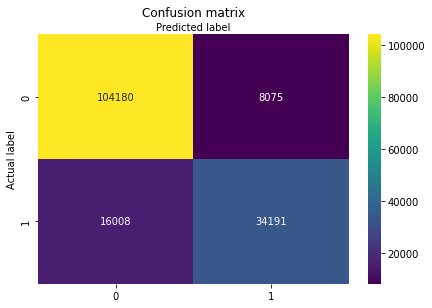

In [ ]:

# # visualisation: 
# # name of classes 
# class_names=[0,1] 
# fig, ax = plt.subplots() 
# tick_marks = np.arange(len(class_names)) 
# plt.xticks(tick_marks, class_names) 
# plt.yticks(tick_marks, class_names) 
# # create heatmap 
# sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="viridis" ,fmt='g') 
# ax.xaxis.set_label_position("top") 
# plt.tight_layout() 
# plt.title('Confusion matrix', y=1.1) 
# plt.xlabel('Actual label')
# plt.ylabel('Predicted label') 
# plt.savefig('LSTM_Model_CM.png', dpi=1080, format='png')

In [ ]:
print(classification_report(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90    112255
           1       0.83      0.66      0.73     50199

    accuracy                           0.85    162454
   macro avg       0.84      0.80      0.82    162454
weighted avg       0.85      0.85      0.85    162454



In [ ]:
# sentiment = ['Negative','Positive']
# sequence = tokenizer.texts_to_sequences(['how given that the tories have not only crashed the economy forced bills to go up with that silly budget made inflation rise amp lowered living standards with pointless brexit amp created the costoflivingcrisis in so just how could labour be worse then them impossible'])
# test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 55ms/step


'Negative'

In [ ]:
# sentiment = ['Negative','Positive']
# sequence = tokenizer.texts_to_sequences(['I am sad'])
# test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 64ms/step


'Negative'

In [ ]:
# sentiment = ['Negative','Positive']
# sequence = tokenizer.texts_to_sequences(['flying with @united is always a great experience'])
# test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 101ms/step


'Positive'

In [ ]:
# sentiment = ['Negative','Positive']
# sequence = tokenizer.texts_to_sequences(['I am sick'])
# test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Negative'

In [ ]:
# sentiment = ['Negative','Positive']
# sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
# test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Negative'

In [ ]:
# sentiment = ['Negative','Positive']
# sequence = tokenizer.texts_to_sequences(['this is really sad'])
# test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 61ms/step


'Negative'

In [ ]:
# testtweets= data[['Cleaned_tweets']]
# testtweets

,Cleaned_tweets
0,cost living crisis political choice yet tory t...
1,costoflivingcrisis stateimposedpoverty do quit...
2,every non tory mp stand today call borisjohnso...
3,ian blackford own show always tory care costof...
4,serious question scottish power say energy gre...
...,...
541723,honestly think liztruss plan cost living crisis
541724,every hour people die poverty uk rise costofli...
541725,jesus billion excess profit yrs time take stre...
541726,attend final leadership debate uk husting fell...


In [ ]:
# testtweets.to_csv('OnlyCleanTweetsData.csv')